## Image classification with deep learning methods.

-- Description --

When you train the network, it is recommended to use the GPU resources of your computer.
This will help you to learn the "know how" of setting up a working Python environment on your computer.
In the case of unavailable Nvidia hardware or problems with your Python environment you can use Google Colab.
Please go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware accelerator.
Although you used your computer successfuly it is highly recommended to give a try to Google Colab environment.


In [144]:
# Import libraries
# These libraries should be sufficient for this Practice.
# However, if any other library is needed, please install it by yourself.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import tensorflow as tf

!pip install medmnist
import medmnist
from medmnist import *

In [133]:
# Parameters
NUM_EPOCHS = 20
BATCH_SIZE = 32
lr = 0.0001
DOWNLOAD_OK = True
data_flag = 'bloodmnist'
im_size = 64
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
num_classes = len(info['label'])
TRAIN_IMAGES = 1000
data_labels = info['label']

# Tupla que contiene los valores asociados a los parámetros mostrados anteriormente,
# con el fin de mejorar la organización de dichos parámetros.
parameters = {"num_epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE, "lr": lr, "download_ok": DOWNLOAD_OK,
              "data_flag": data_flag, "im_size": im_size,"info_task": task, "num_channels": n_channels,
              "num_classes": num_classes,"num_images":TRAIN_IMAGES, "data_labels": data_labels}

# Partial display of information in info
print("Medmnist class: "      , info['python_class'])   #  Medmnist dataset type:   BloodMNIST, ChestMNIST, DermaMNIST, ....
print("Url: "                 , info['url'])            #  Url dir
print("Classification task: " , info['task'])           #  Classification tasks:
print("Class labels: "        , info['label'])          #  Class labels
print("Samples: "             , info['n_samples'])      #  Samples subdatasets


# Preprocesado de datos mediante la definición de la transformación de datos
def preprocessing_data(parameters):
  data_transform = transforms.Compose([
    transforms.Resize((parameters["im_size"],parameters["im_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
  ])

  full_train_dataset = BloodMNIST(split="train", transform=data_transform, download=True)
  full_valid_dataset = BloodMNIST(split="val", transform=data_transform, download=True)
  full_test_dataset = BloodMNIST(split="test", transform=data_transform, download=True)

  idx_train = np.random.choice(len(full_train_dataset),size=parameters["num_images"],replace=False)
  train_dataset = [full_train_dataset[i] for i in idx_train]

  idx_valid = np.random.choice(len(full_valid_dataset),size=300,replace=False)
  valid_dataset = [full_valid_dataset[i] for i in idx_valid]

  idx_test = np.random.choice(len(full_test_dataset),size=600,replace=False)
  test_dataset = [full_test_dataset[i] for i in idx_test]

  train_loader = data.DataLoader(dataset=train_dataset, batch_size=parameters["batch_size"], shuffle=True)
  valid_loader = data.DataLoader(dataset=valid_dataset, batch_size=parameters["batch_size"], shuffle=False)
  test_loader = data.DataLoader(dataset=test_dataset, batch_size=parameters["batch_size"], shuffle=True)

  return train_loader, valid_loader, test_loader, train_dataset, valid_dataset, test_dataset

train_loader,valid_loader,test_loader,train_dataset,valid_dataset,test_dataset = preprocessing_data(parameters)

Medmnist class:  BloodMNIST
Url:  https://zenodo.org/records/10519652/files/bloodmnist.npz?download=1
Classification task:  multi-class
Class labels:  {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
Samples:  {'train': 11959, 'val': 1712, 'test': 3421}
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


In [126]:
## Your code

# Función que permite visualizar los aspectos fundamentales sobre cada
# dataset que se haya descargado/cargado previamente.
def dataset_visualizer(dataset,length_montage):
  for i in range(0,length_montage*length_montage):
    img = dataset[i][0]
    label = str(dataset[i][1]).replace('[','').replace(']','')
    figure = plt.figure(figsize=(2,2))
    plt.imshow(img.permute(1,2,0))
    plt.title(data_labels[label])
    plt.axis("off")
  plt.show()

# Visualizador de los datasets (imágenes) a través de un pipeline DataLoader
def dataloader_visualizer(data_loader,num_batches):
  for batch_idx, (features, labels) in enumerate(data_loader):
      if batch_idx >= num_batches:
        break
      for i in range(len(features)):
        img = features[i].squeeze()
        label = str(labels[i]).replace('tensor([','').replace('])','')
        plt.figure(figsize=(2,2))
        plt.title(label)
        plt.imshow(img.permute(1,2,0))
        plt.axis('off')
        plt.show()

# Visualizador de la red asociada al modelo de aprendizaje
def net_model_visualizer(net_model):
  print(net_model)
  print('Total Parameters:',
       sum([torch.numel(p) for p in net_model.parameters()])
  )
  print('Trainable Parameters:',
       sum([torch.numel(p) for p in net_model.parameters() if p.requires_grad])
  )

#dataset_visualizer(train_dataset,5)

#dataloader_visualizer(train_loader,1)
#dataloader_visualizer(valid_loader,1)
#dataloader_visualizer(test_loader,1)

In [ ]:
# Define a simple CNN model

# Simula una capa que contiene <in_channels> filtros convolucionales de entrada
# y <out_channels> filtros convolucionales de salida
def convolution(in_channels,out_channels):
  layer = nn.Sequential(
      nn.Conv2d(in_channels,out_channels,3),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
  )

  return layer

# Simula una capa de doble convolución
def double_convolution(in_channels,out_channels):
  conv_op = nn.Sequential(
      nn.Conv2d(in_channels,out_channels,3),
      nn.ReLU(),
      nn.Conv2d(in_channels,out_channels,3),
      nn.ReLU()
  )

  return conv_op

class Net(nn.Module):
    def __init__(self, parameters):
        super(Net, self).__init__()

        self.layer1 = convolution(parameters["num_channels"],8)
        self.layer2 = convolution(8,16)
        self.layer3 = convolution(16,32)
        self.layer4 = convolution(32,64)

        self.fc1 = nn.Linear(64,32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32,parameters["num_classes"])

        #End your code

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = F.adaptive_avg_pool2d(x,1).reshape(x.size(0),-1)

        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)

        return x

"""
class UNet(nn.Module):
  def __init__(self,parameters):
    super(UNet,self).__init__()

    self.encoder = nn.Sequential(
      nn.Conv2d(parameters["num_channels"],64,kernel_size=3,padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(64,64,kernel_size=3,padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.decoder = nn.Sequential(
      nn.Conv2d(64,128,kernel_size=3,padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(128,128,kernel_size=3,padding=1),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(128,64,kernel_size=2,stride=2),
      nn.Conv2d(64,parameters["num_classes"],kernel_size=1)
    )

  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x
"""


"""
class UNetCNN(nn.Module):
  def __init__(self,parameters):
    super(UNetCNN,self).__init__()

    self.max_pool2d = nn.MaxPool2d(2,2)

    self.down_conv1 = double_convultion(parameters["n_channels"],8)
    self.down_conv2 = double_convultion(8,16)
    self.down_conv3 = double_convultion(16,32)
    self.down_conv4 = double_convultion(32,64)
    self.down_conv5 = double_convultion(64,128)

    self.up_trans1 = nn.ConvTranspose2d(128,64,2,2)
    self.up_conv1 = double_convultion(128,64)
    self.up_trans2 = nn.ConvTranspose2d(64,32,2,2)
    self.up_conv2 = double_convultion(64,32)
    self.up_trans3 = nn.ConvTranspose2d(32,16,2,2)
    self.up_conv3 = double_convultion(32,16)
    self.up_trans4 = nn.ConvTranspose2d(16,8,2,2)
    self.up_conv4 = double_convultion(16,8)

    self.final_layer = nn.Conv2d(8,parameters["num_classes"],1)

  def forward(self,x):
    print(x.shape)
    down1 = self.down_conv1(x)
    print(down1.shape)
    down2 = self.max_pool2d(down1)
    print(down2.shape)
    down3 = self.down_conv2(down2)
    print(down3.shape)
    down4 = self.max_pool2d(down3)
    print(down4.shape)
    down5 = self.down_conv3(down4)
    print(down5.shape)
    down6 = self.max_pool2d(down5)
    print(down6.shape)
    down7 = self.down_conv4(down6)
    print(down7.shape)
    down8 = self.max_pool2d(down7)
    print(down8.shape)
    down9 = self.down_conv5(down8)
    print(down9.shape)

    up1 = self.up_trans1(down9)
    print(up1.shape)
    x = self.up_conv1(torch.cat([down7,up1],1))

    up2 = self.up_trans2(x)
    print(up2.shape)
    x = self.up_conv2(torch.cat([down5,up2],1))

    up3 = self.up_trans3(x)
    print(up3.shape)
    x = self.up_conv3(torch.cat([down3,up3],1))

    up4 = self.up_trans4(x)
    print(up4.shape)
    x = self.up_conv4(torch.cat([down1,up4],1))

    final_layer = self.final_layer(x)

    print(final_layer.shape)
    return final_layer
"""

"""
class ResNet18(nn.Module):
  def __init__(self,parameters):
    super(ResNet18, self).__init__()

    self.conv1 = nn.Conv2d(parameters["n_channels"],64,7,2,3)
    self.bn1 = nn.BatchNorm2d(64)
    self.maxpool = nn.MaxPool2d(3,2,1)

    self.conv2_block1 = nn.Sequential(
        nn.Conv2d(64,64,3,1,1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64,64,3,1,1),
        nn.BatchNorm2d(64)
    )

    self.conv2_block2 = nn.Sequential(
        nn.Conv2d(64,64,3,1,1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64,64,3,1,1),
        nn.BatchNorm2d(64)
    )

    self.conv3_block1 = nn.Sequential(
        nn.Conv2d(64,128,3,2,1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128,128,3,1,1),
        nn.BatchNorm2d(128)
    )

    self.conv3_block2 = nn.Sequential(
        nn.Conv2d(128,128,3,1,1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128,128,3,1,1),
        nn.BatchNorm2d(128)
    )

    self.conv4_block1 = nn.Sequential(
        nn.Conv2d(128,256,3,2,1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256,256,3,1,1),
        nn.BatchNorm2d(256)
    )

    self.conv4_block2 = nn.Sequential(
        nn.Conv2d(256,256,3,1,1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256,256,3,1,1),
        nn.BatchNorm2d(256)
    )

    self.conv5_block1 = nn.Sequential(
        nn.Conv2d(256,512,3,2,1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512,512,3,1,1),
        nn.BatchNorm2d(512)
    )

    self.conv5_block2 = nn.Sequential(
        nn.Conv2d(512,512,3,1,1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512,512,3,1,1),
        nn.BatchNorm2d(512)
    )

    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    self.fc = nn.Linear(512,parameters["num_classes"])

  def forward(self,x):
    print(x.shape)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.maxpool(x)

    print(x.shape)
    x = self.conv2_block1(x)
    x = self.conv2_block2(x)
    x = self.conv3_block1(x)
    x = self.conv3_block2(x)
    x = self.conv4_block1(x)
    x = self.conv4_block2(x)
    x = self.conv5_block1(x)
    x = self.conv5_block2(x)

    x = self.avgpool(x)
    x = self.fc(x)

    return x
"""

100%|██████████| 10/10 [00:00<00:00, 19.45it/s]



Accuracy: 0.14666666666666667
AUC: 0.6954546913126456
F1 Score: 2.7577639751552794
Confusion Matrix:
tensor([[13.,  0.,  3.,  1.,  0.,  0.,  0.,  0.],
        [25.,  0., 35.,  0.,  0.,  0.,  0.,  0.],
        [ 9.,  0., 15.,  0.,  0.,  0.,  0.,  2.],
        [21.,  0., 18.,  0.,  5.,  0.,  0.,  0.],
        [14.,  0., 10.,  1.,  0.,  0.,  0.,  0.],
        [14.,  0.,  8.,  0.,  3.,  0.,  0.,  0.],
        [25.,  0., 25.,  5.,  4.,  0.,  0.,  0.],
        [ 0.,  0., 28.,  0.,  0.,  0.,  0., 16.]])


100%|██████████| 10/10 [00:00<00:00, 26.28it/s]



Accuracy: 0.3466666666666667
AUC: 0.8760211045761584
F1 Score: 4.204629629629631
Confusion Matrix:
tensor([[ 1.,  0.,  4.,  7.,  5.,  0.,  0.,  0.],
        [ 2.,  0.,  3., 50.,  4.,  0.,  0.,  1.],
        [ 4.,  0., 17.,  2.,  0.,  0.,  0.,  3.],
        [ 7.,  0.,  7., 28.,  2.,  0.,  0.,  0.],
        [ 3.,  0., 12.,  1.,  9.,  0.,  0.,  0.],
        [ 4.,  0.,  0., 20.,  1.,  0.,  0.,  0.],
        [ 1.,  0., 13., 17., 23.,  0.,  5.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:01<00:00,  9.90it/s]



Accuracy: 0.53
AUC: 0.9069845565715111
F1 Score: 4.640907181856363
Confusion Matrix:
tensor([[ 1.,  0.,  1.,  4., 11.,  0.,  0.,  0.],
        [ 1.,  0.,  6., 39.,  8.,  0.,  5.,  1.],
        [ 3.,  0., 14.,  0.,  6.,  0.,  0.,  3.],
        [ 1.,  0.,  5., 33.,  5.,  0.,  0.,  0.],
        [ 0.,  0.,  2.,  0., 23.,  0.,  0.,  0.],
        [ 1.,  0.,  0., 22.,  2.,  0.,  0.,  0.],
        [ 1.,  0.,  1.,  4.,  9.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 20.78it/s]



Accuracy: 0.59
AUC: 0.9220530376753553
F1 Score: 4.671623296158612
Confusion Matrix:
tensor([[ 0.,  0.,  3.,  3., 10.,  0.,  1.,  0.],
        [ 1., 14.,  5., 19.,  3.,  0., 17.,  1.],
        [ 1.,  0., 14.,  0.,  7.,  0.,  1.,  3.],
        [ 0.,  0.,  2., 35.,  6.,  0.,  1.,  0.],
        [ 0.,  0.,  3.,  0., 21.,  0.,  1.,  0.],
        [ 2.,  0.,  0., 20.,  1.,  0.,  2.,  0.],
        [ 1.,  0.,  1.,  3.,  5.,  0., 49.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 37.14it/s]



Accuracy: 0.6666666666666666
AUC: 0.9360127031937716
F1 Score: 4.775704989154014
Confusion Matrix:
tensor([[ 4.,  0.,  1.,  6.,  6.,  0.,  0.,  0.],
        [ 3., 34.,  1., 12.,  2.,  0.,  6.,  2.],
        [ 3.,  0., 15.,  1.,  3.,  0.,  1.,  3.],
        [ 2.,  0.,  2., 36.,  3.,  0.,  1.,  0.],
        [ 1.,  0.,  4.,  1., 19.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 22.,  1.,  0.,  2.,  0.],
        [ 1.,  0.,  1.,  5.,  4.,  0., 48.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 23.61it/s]



Accuracy: 0.7066666666666667
AUC: 0.9416382250902047
F1 Score: 4.846186988367084
Confusion Matrix:
tensor([[ 2.,  0.,  0.,  9.,  6.,  0.,  0.,  0.],
        [ 1., 43.,  1.,  9.,  0.,  0.,  5.,  1.],
        [ 1.,  0., 13.,  4.,  3.,  0.,  1.,  4.],
        [ 2.,  0.,  1., 38.,  2.,  0.,  1.,  0.],
        [ 2.,  0.,  4.,  1., 18.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 23.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  3.,  1.,  0., 54.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 20.71it/s]



Accuracy: 0.7366666666666667
AUC: 0.9458832870267881
F1 Score: 4.884026258205689
Confusion Matrix:
tensor([[ 3.,  0.,  0.,  9.,  5.,  0.,  0.,  0.],
        [ 2., 51.,  0.,  4.,  0.,  0.,  3.,  0.],
        [ 0.,  0., 13.,  5.,  4.,  0.,  1.,  3.],
        [ 2.,  0.,  1., 38.,  2.,  0.,  1.,  0.],
        [ 3.,  0.,  2.,  4., 16.,  0.,  0.,  0.],
        [ 0.,  1.,  0., 22.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  3.,  0.,  0., 56.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 38.78it/s]



Accuracy: 0.73
AUC: 0.9476067691495349
F1 Score: 4.911062906724513
Confusion Matrix:
tensor([[ 2.,  0.,  0., 10.,  5.,  0.,  0.,  0.],
        [ 2., 54.,  0.,  2.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  8.,  5.,  9.,  0.,  1.,  3.],
        [ 2.,  0.,  1., 37.,  2.,  0.,  2.,  0.],
        [ 1.,  0.,  1.,  6., 17.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 23.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  2.,  0.,  0., 57.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 39.86it/s]



Accuracy: 0.73
AUC: 0.9500576132781917
F1 Score: 4.891114982578398
Confusion Matrix:
tensor([[ 2.,  0.,  0., 10.,  5.,  0.,  0.,  0.],
        [ 1., 56.,  0.,  1.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  8.,  5.,  9.,  0.,  1.,  3.],
        [ 1.,  0.,  1., 38.,  2.,  0.,  2.,  0.],
        [ 2.,  0.,  1.,  7., 15.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 24.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  3.,  0.,  0., 56.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 40.57it/s]



Accuracy: 0.7466666666666667
AUC: 0.9520899631175956
F1 Score: 4.91004366812227
Confusion Matrix:
tensor([[ 3.,  0.,  0., 10.,  4.,  0.,  0.,  0.],
        [ 1., 57.,  0.,  1.,  0.,  0.,  1.,  0.],
        [ 0.,  0., 10.,  5.,  6.,  0.,  1.,  4.],
        [ 0.,  0.,  1., 40.,  1.,  0.,  2.,  0.],
        [ 1.,  0.,  1.,  9., 14.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 24.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  3.,  0.,  0., 56.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 28.17it/s]



Accuracy: 0.74
AUC: 0.9543247486325126
F1 Score: 4.896641953772352
Confusion Matrix:
tensor([[ 2.,  0.,  0., 11.,  4.,  0.,  0.,  0.],
        [ 1., 57.,  0.,  1.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  9.,  5.,  7.,  0.,  1.,  4.],
        [ 0.,  0.,  1., 40.,  1.,  0.,  2.,  0.],
        [ 1.,  0.,  1.,  9., 14.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 24.,  0.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  2.,  0.,  0., 56.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 24.94it/s]



Accuracy: 0.7566666666666667
AUC: 0.9550236881993273
F1 Score: 4.919439579684763
Confusion Matrix:
tensor([[ 4.,  0.,  0.,  9.,  4.,  0.,  0.,  0.],
        [ 1., 57.,  0.,  1.,  0.,  0.,  1.,  0.],
        [ 0.,  0., 10.,  5.,  7.,  0.,  1.,  3.],
        [ 0.,  0.,  1., 40.,  1.,  0.,  2.,  0.],
        [ 2.,  0.,  0.,  8., 15.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 24.,  0.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  1.,  0.,  0., 57.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 34.61it/s]



Accuracy: 0.7533333333333333
AUC: 0.958083416849958
F1 Score: 4.910683012259194
Confusion Matrix:
tensor([[ 4.,  0.,  0.,  9.,  4.,  0.,  0.,  0.],
        [ 1., 58.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  9.,  5.,  7.,  0.,  1.,  4.],
        [ 0.,  0.,  1., 40.,  1.,  0.,  2.,  0.],
        [ 2.,  0.,  0.,  8., 15.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 24.,  0.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  2.,  0.,  0., 56.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 24.08it/s]



Accuracy: 0.75
AUC: 0.9596547610517333
F1 Score: 4.909490333919156
Confusion Matrix:
tensor([[ 4.,  0.,  0.,  9.,  4.,  0.,  0.,  0.],
        [ 1., 57.,  0.,  1.,  0.,  0.,  1.,  0.],
        [ 1.,  0., 10.,  3.,  8.,  0.,  1.,  3.],
        [ 1.,  0.,  1., 39.,  1.,  0.,  2.,  0.],
        [ 2.,  0.,  0.,  8., 15.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 24.,  0.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  2.,  0.,  0., 56.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 13.15it/s]



Accuracy: 0.7566666666666667
AUC: 0.9612553630451826
F1 Score: 4.931567328918322
Confusion Matrix:
tensor([[ 4.,  1.,  0.,  8.,  4.,  0.,  0.,  0.],
        [ 1., 59.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  0., 10.,  4.,  5.,  0.,  1.,  4.],
        [ 2.,  0.,  1., 38.,  1.,  0.,  2.,  0.],
        [ 2.,  0.,  0.,  8., 15.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 24.,  0.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  1.,  0.,  0., 57.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 42.39it/s]



Accuracy: 0.7533333333333333
AUC: 0.9618666582556223
F1 Score: 4.914159292035398
Confusion Matrix:
tensor([[ 4.,  0.,  0.,  9.,  4.,  0.,  0.,  0.],
        [ 1., 59.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  0., 10.,  2.,  8.,  0.,  1.,  3.],
        [ 2.,  0.,  1., 38.,  1.,  0.,  2.,  0.],
        [ 3.,  0.,  0.,  7., 15.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 24.,  0.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  2.,  0.,  0., 56.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 25.58it/s]



Accuracy: 0.7733333333333333
AUC: 0.9628983280495875
F1 Score: 4.963093145869946
Confusion Matrix:
tensor([[ 5.,  0.,  0.,  8.,  4.,  0.,  0.,  0.],
        [ 1., 59.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  0., 12.,  1.,  7.,  0.,  1.,  3.],
        [ 2.,  0.,  1., 37.,  1.,  0.,  3.,  0.],
        [ 0.,  0.,  0.,  8., 17.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 24.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 58.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 29.97it/s]



Accuracy: 0.7633333333333333
AUC: 0.9648650373788006
F1 Score: 4.925399644760214
Confusion Matrix:
tensor([[ 5.,  0.,  0.,  8.,  4.,  0.,  0.,  0.],
        [ 1., 59.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  0., 13.,  1.,  7.,  0.,  1.,  2.],
        [ 2.,  0.,  1., 37.,  1.,  0.,  3.,  0.],
        [ 3.,  0.,  0.,  7., 15.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 24.,  0.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  2.,  0.,  0., 56.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 27.53it/s]



Accuracy: 0.7733333333333333
AUC: 0.9665317057059433
F1 Score: 4.935771632471007
Confusion Matrix:
tensor([[ 7.,  0.,  0.,  6.,  4.,  0.,  0.,  0.],
        [ 1., 59.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  0., 14.,  1.,  5.,  0.,  1.,  3.],
        [ 2.,  1.,  1., 36.,  1.,  0.,  3.,  0.],
        [ 4.,  0.,  0.,  6., 15.,  0.,  0.,  0.],
        [ 1.,  0.,  0., 23.,  0.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  1.,  0.,  0., 57.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


100%|██████████| 10/10 [00:00<00:00, 21.92it/s]



Accuracy: 0.7933333333333333
AUC: 0.9684138505971571
F1 Score: 4.936208445642408
Confusion Matrix:
tensor([[ 8.,  0.,  0.,  5.,  4.,  0.,  0.,  0.],
        [ 1., 59.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  0., 18.,  1.,  1.,  0.,  1.,  3.],
        [ 2.,  1.,  1., 37.,  1.,  0.,  2.,  0.],
        [ 4.,  0.,  0.,  5., 16.,  0.,  0.,  0.],
        [ 1.,  0.,  0., 23.,  0.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  2.,  0.,  0., 56.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 44.]])


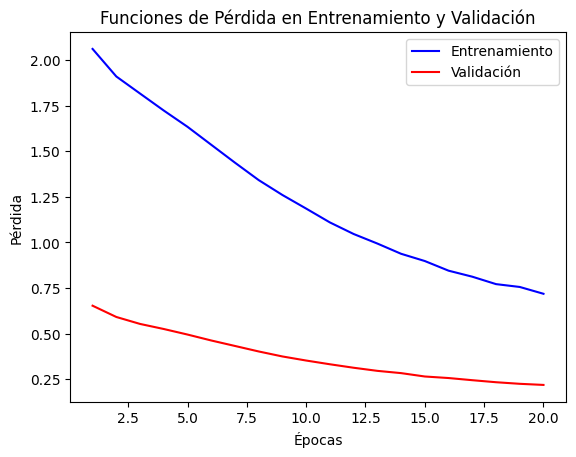

In [145]:
# Train and validate the model
def train_epoch(model,train_loader,optimizer,criterion,epoch,parameters):
    train_loss_epoch = 0

    for batch_idx, (X_batch, y_batch) in tqdm(enumerate(train_loader),total=len(train_loader)):
        outputs = model(X_batch)

        if parameters["info_task"] == 'binary-class':
          y_batch = y_batch.to(torch.float32)
        else:
          y_batch = y_batch.squeeze().long()

        loss = criterion(outputs,y_batch)

        train_loss_epoch += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss_epoch /= parameters["batch_size"]

    return train_loss_epoch

def validate_epoch(model,valid_loader,criterion,epoch,parameters):
    valid_loss_epoch = 0

    y_true = torch.tensor([])
    y_score = torch.tensor([])

    with torch.no_grad():
      for batch_idx, (X_batch, y_batch) in tqdm(enumerate(valid_loader),total=len(valid_loader)):
          outputs = model(X_batch)

          if parameters["info_task"] == 'binary-class':
            y_batch = y_batch.to(torch.float32)
          else:
            y_batch = y_batch.squeeze().long()

          loss = criterion(outputs,y_batch)

          valid_loss_epoch += loss.item()

          outputs = outputs.softmax(1)
          y_batch = y_batch.resize_(len(y_batch),1)

          y_true = torch.cat((y_true, y_batch),0)
          y_score = torch.cat((y_score, outputs),0)

      y_true = y_true.numpy()
      y_score = y_score.detach().numpy()

      y_labels = np.argmax(y_score,1)[...,np.newaxis]

      acc = np.sum(y_true == y_labels) / np.sum(y_true == y_true)

      auc = roc_auc_score(y_true,y_score,multi_class='ovr')
      f1 = f1_score_function(y_true,y_labels)
      matrix = confusion_matrix(torch.from_numpy(y_true),torch.from_numpy(y_labels),parameters["num_classes"])

      print("\nAccuracy:", acc)
      print("AUC:", auc)
      print("F1 Score:", f1.item())
      print("Confusion Matrix:")
      print(matrix)

      valid_loss_epoch /= parameters["batch_size"]

      return valid_loss_epoch

#Dibuja una gráfica asociada a las funciones de coste para entrenamiento y validación
def loss_function_graphics(epochs,train_loss_epoch,valid_loss_epoch):
  plt.plot(epochs, train_loss_epoch, 'b', label='Entrenamiento')
  plt.plot(epochs, valid_loss_epoch, 'r', label='Validación')
  plt.title('Funciones de Pérdida en Entrenamiento y Validación')
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  plt.show()

def f1_score_function(y_true,y_pred):
  tp = (y_true * y_pred).sum()
  fp = ((1 - y_true) * y_pred).sum()
  fn = (y_true * (1 - y_pred)).sum()

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  f1 = 2 * (precision * recall) / (precision + recall)

  return f1

def confusion_matrix(y_true,y_pred,num_classes):
  y_true = y_true.long()
  y_pred = y_pred.long()

  confusion_matrix = torch.zeros(num_classes,num_classes)

  for t, p in zip(y_true.view(-1), y_pred.view(-1)):
      confusion_matrix[t, p] += 1

  return confusion_matrix

def model_training(model,optimizer,criterion,train_loader,valid_loader,parameters):
  train_loss_epoch = []
  valid_loss_epoch = []
  epochs = range(1,parameters["num_epochs"]+1)

  for epoch in range(parameters["num_epochs"]):
    model.train()
    train_loss = train_epoch(model,train_loader,optimizer,criterion,epoch,parameters)
    model.eval()
    valid_loss = validate_epoch(model,valid_loader,criterion,epoch,parameters)

    train_loss_epoch.append(train_loss)
    valid_loss_epoch.append(valid_loss)

  loss_function_graphics(epochs,train_loss_epoch,valid_loss_epoch)


model = Net(parameters)

#net_model_visualizer(model)

if parameters["info_task"] == 'binary-class':
  optimizer = torch.optim.SGD(model.parameters(),lr=parameters["lr"])
  criterion = nn.BCEWithLogitsLoss()
else:
  optimizer = torch.optim.Adam(model.parameters(),lr=parameters["lr"])
  criterion = nn.CrossEntropyLoss()

model_training(model,optimizer,criterion,train_loader,valid_loader,parameters)

#Evaluation

Finally, implement the evaluation of the object clasification task. You can implement any metric you want, though the most common are accuracy and AUC (one class against all for the multiclass task). You can use torch.no_grad() for speeding up predictions when no gradients are needed.

How do you compare with the MedMNIST benchmarks?

In [148]:
def model_final_test(model,test_loader,criterion,parameters):
  model.eval()
  test_loss_batch = []

  test_loss = 0
  y_true = torch.tensor([])
  y_score = torch.tensor([])

  with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in tqdm(enumerate(test_loader),total=len(test_loader)):
      outputs = model(X_batch)
      y_batch = y_batch.squeeze().long()

      loss = criterion(outputs,y_batch)

      test_loss += loss.item()

      outputs = outputs.softmax(1)
      y_batch = y_batch.resize_(len(y_batch),1)

      y_true = torch.cat((y_true, y_batch),0)
      y_score = torch.cat((y_score, outputs),0)

    y_true = y_true.numpy()
    y_score = y_score.detach().numpy()

    y_labels = np.argmax(y_score,1)[...,np.newaxis]

    test_acc = np.sum(y_true == y_labels) / np.sum(y_true == y_true)
    test_auc = roc_auc_score(y_true,y_score,multi_class='ovr')
    test_f1 = f1_score_function(y_true,y_labels)
    test_matrix = confusion_matrix(torch.from_numpy(y_true),torch.from_numpy(y_labels),parameters["num_classes"])
    test_loss /= parameters["batch_size"]

    print("\nAccuracy:", test_acc)
    print("AUC:", test_auc)
    print("F1 Score:", test_f1.item())
    print("Loss Function",test_loss)
    print("Confusion Matrix:")
    print(test_matrix)

model_final_test(model,test_loader,criterion,parameters)

100%|██████████| 19/19 [00:00<00:00, 27.58it/s]


Accuracy: 0.7633333333333333
AUC: 0.9635551037409879
F1 Score: 4.8172091964488954
Loss Function 0.43828926980495453
Confusion Matrix:
tensor([[ 12.,   3.,   0.,  18.,   4.,   0.,   0.,   0.],
        [  0., 114.,   0.,   1.,   0.,   0.,   2.,   0.],
        [  4.,   0.,  41.,   3.,   2.,   0.,  10.,  10.],
        [  9.,   4.,   1.,  71.,   3.,   0.,   5.,   0.],
        [  3.,   1.,   2.,   5.,  25.,   0.,   0.,   0.],
        [  1.,   1.,   0.,  44.,   0.,   0.,   1.,   0.],
        [  0.,   3.,   0.,   2.,   0.,   0., 121.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  74.]])
